In [1]:
import seaborn as sns

In [2]:
RESULTS_PATH = "/wfd_storage/eval_results_test/eval_results"
DATASET_PATH = "/wfd_storage/wikifactdiff.jsonl"
OLD_ENT_IMP_PATH = "/wfd_storage/old_entities_importance.json"
TF_IDF_INDEX_PATH = "/wfd_storage/tfidf_index"

In [3]:
import os

def get_leaf_directories(path, target_depth):
    # List to hold the leaf directories
    leaf_directories = []
    
    # Walk through the specified path
    for root, dirs, files in os.walk(path):
        depth = root[len(path):].count(os.path.sep) + 1  # +1 to include the starting directory in the depth count
        
        # Stop walking through the directory tree when reaching target_depth + 1
        if depth > target_depth:
            dirs[:] = []  # Don't need to go deeper
        
        # If at target_depth and there are no subdirectories, append this directory to the list
        if depth == target_depth and not dirs:
            leaf_directories.append(root)
    
    return leaf_directories


# Specify the path to start from
path = RESULTS_PATH

# Specify the target depth
target_depth = 4

# Get the leaf directories at target_depth
leaf_directories = get_leaf_directories(path, target_depth)


In [4]:
import os.path as osp
import numpy as np
import scipy
from typing import Iterable, Union
import math

def read_list(path : str) -> list[str]:
    with open(path, 'r') as f:
        l = [x.strip() for x in f]
    return l

def sparse_dot(v1, v2):
    _, idx1, idx2 = np.intersect1d(v1.indices, v2.indices, assume_unique=True, return_indices=True)
    dot_product = (v1.data[idx1] * v2.data[idx2]).sum()
    return dot_product

def cosine_distance_sparse(vector_a, vector_b):
    """
    Compute the cosine distance between two sparse vectors.
    
    Parameters:
    - vector_a: scipy.sparse.csr_matrix
        A sparse vector.
    - vector_b: scipy.sparse.csr_matrix
        A sparse vector.
    
    Returns:
    float
        The cosine distance between vector_a and vector_b.
    """
    # Dot product of two sparse vectors is the sum of the product of corresponding non-zero elements.
    dot_product = sparse_dot(vector_a, vector_b)
    
    # Computing norms (L2) of the input vectors
    norm_a = math.sqrt(sparse_dot(vector_a, vector_a))
    norm_b = math.sqrt(sparse_dot(vector_b, vector_b))
    
    # Calculating cosine distance
    distance = 1 - dot_product / (norm_a * norm_b)
    
    return distance

class CosComputer:
    def __init__(self) -> None:
        self.load_index()
    
    def load_index(self):
        print('Loading entity names...')
        self.entities_in_index = read_list(osp.join(TF_IDF_INDEX_PATH, 'entities_old.txt'))
        self.entities_new = read_list(osp.join(TF_IDF_INDEX_PATH, 'entities_new.txt'))
        self.entities_in_index_name2idx = { k : i for i,k in enumerate(self.entities_in_index)}
        self.entities_new_name2idx = { k : i for i,k in enumerate(self.entities_new)}

        print('Loading TF-IDF sparse matrix...')
        self.tfidf_old = scipy.sparse.load_npz(osp.join(TF_IDF_INDEX_PATH,'features_sparses_old.npz'))
        self.tfidf_new = scipy.sparse.load_npz(osp.join(TF_IDF_INDEX_PATH,'features_sparses_new.npz'))
    
    def get_vectors(self, ids : Union[str, Iterable[str]]) -> Union[np.ndarray, list[np.ndarray]]:
        if is_single := isinstance(ids, str):
            ids = [ids]
        vectors = []
        for ent_id in ids:
            for version, id2int in (('old', self.entities_in_index_name2idx), ('new', self.entities_new_name2idx)):
                idx = id2int.get(ent_id, None)
                if idx is not None:
                    break
            else:
                print('WARNING : %s ID not found in the index' % ent_id)
                return None
            if version == 'old':
                vector = self.tfidf_old[idx]
            else:
                vector = self.tfidf_new[idx]
            vectors.append(vector)
        if is_single:
            return vectors[0]
        return vectors

    def compute_cos(self, ent1 : str, ent2 : str) -> float:
        vec1 = self.get_vectors(ent1)
        vec2 = self.get_vectors(ent2)
        return cosine_distance_sparse(vec1, vec2)
cos_computer = CosComputer()

Loading entity names...
Loading TF-IDF sparse matrix...


In [5]:
from dsets.wikifactdiff import FunctionalWikiFactDiffDataset
import json
import pandas as pd

dataset = FunctionalWikiFactDiffDataset(adapt_to_cf_format=False).data
dataset = {x['case_id'] :x for x in dataset}
old_ent_imp = json.load(open(OLD_ENT_IMP_PATH))

Keep only replace updates.
Undersample updates on the "population" relation by a factor of 14
Loaded dataset with 10373 elements


In [6]:
dataset_rand = FunctionalWikiFactDiffDataset(adapt_to_cf_format=False, use_random_neighbors=True).data
dataset_rand = {x['case_id'] :x for x in dataset_rand}

Using random neighbors to compute specificity.
Keep only replace updates.
Undersample updates on the "population" relation by a factor of 14
Loaded dataset with 10373 elements


In [71]:
pd_data = []
failed = []

for i, leaf in enumerate(leaf_directories, start=1):
    print("[%s/%s] %s" % (i,len(leaf_directories), leaf))
    neighbor_method, algo = leaf.split('/')[-3].split('__')
    for file in os.listdir(leaf):
        if file == 'params.json':
            continue
        data = json.load(open(osp.join(leaf,file)))
        case_id = data['case_id']
        if data.get('failed', False):
            failed.append(case_id)
        wfd_instance = dataset[case_id] if neighbor_method != 'random_neighbors' else dataset_rand[case_id]
        old_subject_popularity = old_ent_imp.get(wfd_instance['subject']['id'])
        new_subject_popularity = wfd_instance['subject_popularity']

        new_update, old_update = sorted(wfd_instance['objects'], key=lambda x : x['decision'])
        old_object_id = old_update.get('id')
        old_object_popularity =  old_ent_imp.get(old_object_id) if old_object_id is not None else None
        old_obj_type = 'Entity' if old_object_id is not None else old_update.get('description')
        new_object_id = new_update.get('id')
        new_object_popularity =  old_ent_imp.get(new_object_id) if new_object_id is not None else None
        new_obj_type = 'Entity' if new_object_id is not None else new_update.get('description')

        relation_id = wfd_instance['relation']['id']
        probs = data['post']
        update_prompt_target_true = probs['rewrite_prompts_probs'][0]['target_true']
        update_prompt_target_new = probs['rewrite_prompts_probs'][0]['target_new']
        paraphrase_prompt_target_true = np.array([x['target_true'] for x in probs['paraphrase_prompts_probs']])
        paraphrase_prompt_target_new = np.array([x['target_new'] for x in probs['paraphrase_prompts_probs']])
        neighborhood_prompt_pre_obj_true = np.array([x['pre_object_true'] for x in probs['neighborhood_prompts_probs']])
        neighborhood_prompt_post_obj_true = np.array([x['post_object_true'] for x in probs['neighborhood_prompts_probs']])
        distances_ = np.array([x['objects'][0]['dist'] for x in wfd_instance['neighborhood']])
        distances = np.array([cos_computer.compute_cos(x['subject']['id'], wfd_instance['subject']['id']) for x in wfd_instance['neighborhood']])
        # print([(wfd_instance['subject']['label'], x['subject']['label'], x['objects'][0]['dist'], cos_computer.compute_cos(x['subject']['id'], wfd_instance['subject']['id'])) for x in wfd_instance['neighborhood']])
        ngram_entropy = probs['ngram_entropy']
        to_append = {
            'case_id' : case_id,
            'neighbor_method' : neighbor_method,
            'algo' : algo,
            'old_subject_popularity' : old_subject_popularity,
            'new_subject_popularity' : new_subject_popularity,
            'old_object_popularity' : old_object_popularity,
            'old_obj_type' : old_obj_type,
            'new_object_popularity' : new_object_popularity,
            'new_obj_type' : new_obj_type,
            'relation_id' : relation_id,
            'update_prompt_target_true' : update_prompt_target_true,
            'update_prompt_target_new' : update_prompt_target_new,
            'update_prompt_correct' : probs['rewrite_prompts_correct'][0],
            'paraphrase_prompts_correct' : probs['paraphrase_prompts_correct'],
            'paraphrase_prompt_target_true' : paraphrase_prompt_target_true,
            'paraphrase_prompt_target_new' : paraphrase_prompt_target_new,
            'neighborhood_prompt_pre_obj_true' : neighborhood_prompt_pre_obj_true,
            'neighborhood_prompt_post_obj_true' : neighborhood_prompt_post_obj_true,
            '_neighborhood_distances' : distances_,
            'neighborhood_distances' : distances,
            'ngram_entropy' : ngram_entropy,
            'execution_time' : data['time']
        }
        pd_data.append(to_append)

df = pd.DataFrame(data=pd_data)
failed = list(set(failed))

[1/14] /wfd_storage/eval_results_test/eval_results/tf_idf_neighbors__ROME/ROME/run_000
[2/14] /wfd_storage/eval_results_test/eval_results/tf_idf_neighbors__MEND/MEND/run_000
[3/14] /wfd_storage/eval_results_test/eval_results/tf_idf_neighbors__MEMIT/MEMIT/run_000
[4/14] /wfd_storage/eval_results_test/eval_results/random_neighbors__PROMPT/PROMPT/run_000
[5/14] /wfd_storage/eval_results_test/eval_results/tf_idf_neighbors__FT_constr/FT/run_000
[6/14] /wfd_storage/eval_results_test/eval_results/random_neighbors__FT_constr/FT/run_000
[7/14] /wfd_storage/eval_results_test/eval_results/random_neighbors__IDENTITY/IDENTITY/run_000
[8/14] /wfd_storage/eval_results_test/eval_results/random_neighbors__ROME/ROME/run_000
[9/14] /wfd_storage/eval_results_test/eval_results/tf_idf_neighbors__IDENTITY/IDENTITY/run_000
[10/14] /wfd_storage/eval_results_test/eval_results/tf_idf_neighbors__FT_unconstr/FT/run_000
[11/14] /wfd_storage/eval_results_test/eval_results/random_neighbors__MEMIT/MEMIT/run_000
[12/14

In [72]:
df = df.sort_values(['neighbor_method', 'algo', 'case_id'])

In [73]:
s = set()
for c, group in df.groupby(['algo', 'neighbor_method']):
    if len(s) == 0:
        s = set(group['case_id'])
    else:
        s.intersection_update(group['case_id'])
s.difference_update(failed)
df2 = df[np.isin(df['case_id'], list(s))]

In [74]:
# lower_idx = df[df['neighbor_method'] == 'tf_idf_neighbors']['algo'].value_counts().min()
# df2 = df.groupby(['algo', 'neighbor_method']).agg(lower_idx)
# df2 = df2[np.isin(df2['case_id'], failed, invert=True)]

In [75]:
mean_df = df2.copy()
mean_df['_test_distance'] = mean_df.apply(lambda x : (x['_neighborhood_distances'] - x['neighborhood_distances']).mean(), axis=1)
mean_df['efficacy_d'] = np.exp(-mean_df['update_prompt_target_new']) - np.exp(-mean_df['update_prompt_target_true'] )
mean_df['efficacy_s'] = mean_df['update_prompt_target_new'] < mean_df['update_prompt_target_true']
mean_df['generalization_d'] = mean_df.apply(lambda x : (np.exp(-x['paraphrase_prompt_target_new']) - np.exp(-x['paraphrase_prompt_target_true'])).mean(), axis=1)
mean_df['generalization_s'] = mean_df.apply(lambda x : (x['paraphrase_prompt_target_new'] < x['paraphrase_prompt_target_true']).mean(), axis=1)
mean_df['specificity_d'] = mean_df.apply(lambda x : (np.exp(-x['neighborhood_prompt_post_obj_true']) - np.exp(-x['neighborhood_prompt_pre_obj_true'])).__abs__().mean(), axis=1)
mean_df['specificity_dd'] = mean_df.apply(lambda x : np.clip(np.exp(-x['neighborhood_prompt_post_obj_true']) - np.exp(-x['neighborhood_prompt_pre_obj_true']),a_max=0, a_min=-np.inf).mean(), axis=1)

/tmp/ipykernel_413688/3384864734.py:2: RuntimeWarning: Mean of empty slice.
  mean_df['_test_distance'] = mean_df.apply(lambda x : (x['_neighborhood_distances'] - x['neighborhood_distances']).mean(), axis=1)
/opt/conda/envs/memit/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_413688/3384864734.py:7: RuntimeWarning: Mean of empty slice.
  mean_df['specificity_d'] = mean_df.apply(lambda x : (np.exp(-x['neighborhood_prompt_post_obj_true']) - np.exp(-x['neighborhood_prompt_pre_obj_true'])).__abs__().mean(), axis=1)
/opt/conda/envs/memit/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_413688/3384864734.py:8: RuntimeWarning: Mean of empty slice.
  mean_df['specificity_dd'] = mean_df.apply(lambda x : np.clip(np.exp(-x['neighborhood_prompt_post_obj_true']) - 

Mean absolute error 0.018814564331464414


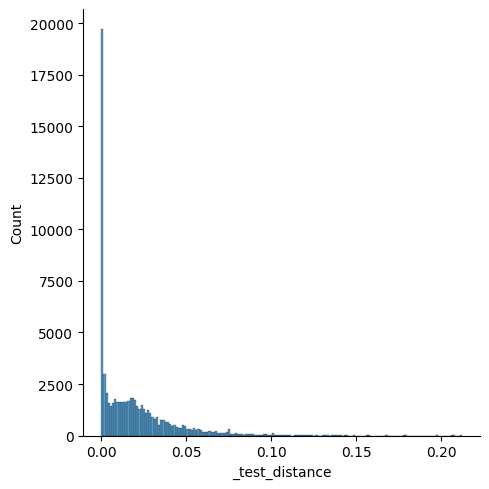

In [79]:
# How accurate is NMSlib distance ?
print("Mean absolute error", mean_df[mean_df['neighbor_method'] != 'random_neighbors']['_test_distance'].__abs__().mean())
sns.displot(mean_df[mean_df['neighbor_method'] != 'random_neighbors']['_test_distance'].__abs__())

/tmp/ipykernel_413688/3807156290.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([y for x in mean_df[mean_df['neighbor_method'] != 'random_neighbors']['_neighborhood_distances'] for y in x])
/tmp/ipykernel_413688/3807156290.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot([y for x in mean

<Axes: ylabel='Density'>

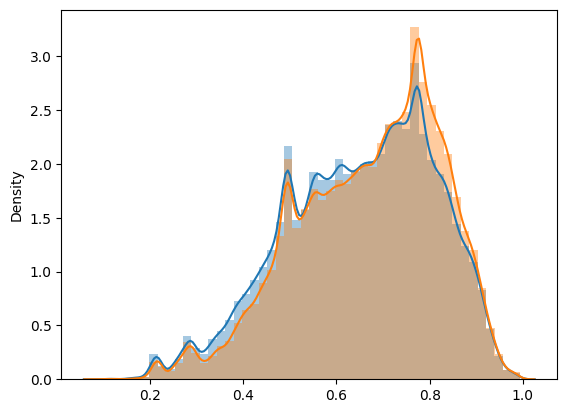

In [77]:
import seaborn as sns

sns.distplot([y for x in mean_df[mean_df['neighbor_method'] != 'random_neighbors']['_neighborhood_distances'] for y in x])
sns.distplot([y for x in mean_df[mean_df['neighbor_method'] != 'random_neighbors']['neighborhood_distances'] for y in x])

In [80]:
x = mean_df.iloc[0]
x['neighborhood_distances'], x['neighborhood_prompt_pre_obj_true']

(array([0.99957818, 0.99741668, 0.99822367, 0.99956003, 0.99410109,
        0.99633029, 0.99552556, 0.99191358, 0.99872487, 0.999559  ]),
 array([10.2471199 ,  7.6394558 ,  4.57139349,  2.15662694,  6.49488449,
         2.70259714,  5.44324636,  1.67569077,  6.49627066,  4.58411646]))

In [81]:
mean_df.apply(lambda x : len(x['neighborhood_distances']) == len(x['neighborhood_prompt_post_obj_true']), axis=1).mean()

1.0

# General metrics

In [84]:
import math
def confidence_interval(frame : pd.DataFrame):
    m = frame.mean(axis=0, skipna=True)
    s = frame.std(axis=0, skipna=True)
    c = len(frame) - frame.isna().sum(axis=0)
    d = 1.96*s/math.sqrt(c)

    if frame.name not in ('execution_time', 'ngram_entropy'):
        m *= 100
        d *= 100

    return '%.1f ± %.1f' % (m,d)
metrics = mean_df[(mean_df['neighbor_method'] == 'tf_idf_neighbors')].groupby('algo')[['efficacy_d', 'efficacy_s', 'generalization_d', 'generalization_s', 'specificity_d', 'specificity_dd', 'ngram_entropy', 'execution_time']].agg(confidence_interval)
metrics

,efficacy_d,efficacy_s,generalization_d,generalization_s,specificity_d,specificity_dd,ngram_entropy,execution_time
algo,,,,,,,,
FT_constr,12.9 ± 0.6,73.1 ± 0.9,1.1 ± 0.2,53.4 ± 0.8,0.8 ± 0.0,-0.3 ± 0.0,5.1 ± 0.0,1.8 ± 0.0
FT_unconstr,46.0 ± 0.5,99.6 ± 0.1,45.7 ± 0.5,99.5 ± 0.1,6.9 ± 0.2,-5.6 ± 0.2,0.7 ± 0.0,1.0 ± 0.0
IDENTITY,-1.4 ± 0.2,44.6 ± 1.0,-1.3 ± 0.2,44.4 ± 0.9,0.1 ± 0.0,-0.0 ± 0.0,5.2 ± 0.0,0.0 ± 0.0
MEMIT,87.3 ± 0.3,99.5 ± 0.1,41.8 ± 0.6,94.5 ± 0.3,0.9 ± 0.1,-0.3 ± 0.0,5.2 ± 0.0,38.4 ± 0.0
MEND,64.4 ± 0.6,99.4 ± 0.2,28.7 ± 0.5,96.5 ± 0.3,2.8 ± 0.1,-1.0 ± 0.1,4.9 ± 0.0,1.3 ± 0.0
PROMPT,4.5 ± 0.2,75.1 ± 0.8,1.0 ± 0.1,55.6 ± 0.7,6.7 ± 0.2,-6.7 ± 0.2,4.4 ± 0.0,0.0 ± 0.0
ROME,95.5 ± 0.2,99.7 ± 0.1,59.7 ± 0.6,97.9 ± 0.2,1.3 ± 0.1,-0.6 ± 0.1,5.2 ± 0.0,4.8 ± 0.0


In [85]:
metrics.loc[['IDENTITY', 'FT_unconstr', 'FT_constr', 'MEND', 'ROME', 'MEMIT', 'PROMPT']]

,efficacy_d,efficacy_s,generalization_d,generalization_s,specificity_d,specificity_dd,ngram_entropy,execution_time
algo,,,,,,,,
IDENTITY,-1.4 ± 0.2,44.6 ± 1.0,-1.3 ± 0.2,44.4 ± 0.9,0.1 ± 0.0,-0.0 ± 0.0,5.2 ± 0.0,0.0 ± 0.0
FT_constr,12.9 ± 0.6,73.1 ± 0.9,1.1 ± 0.2,53.4 ± 0.8,0.8 ± 0.0,-0.3 ± 0.0,5.1 ± 0.0,1.8 ± 0.0
FT_unconstr,46.0 ± 0.5,99.6 ± 0.1,45.7 ± 0.5,99.5 ± 0.1,6.9 ± 0.2,-5.6 ± 0.2,0.7 ± 0.0,1.0 ± 0.0
MEND,64.4 ± 0.6,99.4 ± 0.2,28.7 ± 0.5,96.5 ± 0.3,2.8 ± 0.1,-1.0 ± 0.1,4.9 ± 0.0,1.3 ± 0.0
ROME,95.5 ± 0.2,99.7 ± 0.1,59.7 ± 0.6,97.9 ± 0.2,1.3 ± 0.1,-0.6 ± 0.1,5.2 ± 0.0,4.8 ± 0.0
MEMIT,87.3 ± 0.3,99.5 ± 0.1,41.8 ± 0.6,94.5 ± 0.3,0.9 ± 0.1,-0.3 ± 0.0,5.2 ± 0.0,38.4 ± 0.0
PROMPT,4.5 ± 0.2,75.1 ± 0.8,1.0 ± 0.1,55.6 ± 0.7,6.7 ± 0.2,-6.7 ± 0.2,4.4 ± 0.0,0.0 ± 0.0


In [27]:
import math
def confidence_interval(frame : pd.DataFrame):
    m = frame.mean(axis=0, skipna=True)
    s = frame.std(axis=0, skipna=True)
    c = len(frame) - frame.isna().sum(axis=0)
    d = 1.96*s/math.sqrt(c)

    return '%.2f ± %.2f' % (m, d)
metrics = mean_df[(mean_df['neighbor_method'] == 'tf_idf_neighbors')].groupby('algo')[['efficacy_d', 'efficacy_s', 'generalization_d', 'generalization_s', 'specificity_d', 'specificity_dd', 'ngram_entropy', 'execution_time']].agg(confidence_interval)
metrics

,efficacy_d,efficacy_s,generalization_d,generalization_s,specificity_d,specificity_dd,ngram_entropy,execution_time
algo,,,,,,,,
FT_constr,11.31 ± 0.74,65.01 ± 1.26,0.78 ± 0.28,47.84 ± 1.16,0.83 ± 0.04,-0.30 ± 0.02,532.26 ± 1.47,248.35 ± 1.07
FT_unconstr,41.00 ± 0.72,88.78 ± 0.83,40.86 ± 0.74,88.75 ± 0.83,8.64 ± 0.29,-5.26 ± 0.22,204.83 ± 2.02,142.29 ± 1.02
IDENTITY,-1.41 ± 0.28,39.90 ± 1.29,-1.30 ± 0.26,39.23 ± 1.17,0.08 ± 0.00,-0.04 ± 0.00,536.29 ± 1.34,0.00 ± 0.00
MEMIT,83.14 ± 0.69,93.33 ± 0.66,41.15 ± 0.85,87.44 ± 0.76,0.97 ± 0.08,-0.32 ± 0.04,543.66 ± 1.44,4118.90 ± 5.31
MEND,57.41 ± 0.94,92.37 ± 0.70,26.52 ± 0.72,89.07 ± 0.71,4.67 ± 0.24,-1.12 ± 0.10,509.89 ± 1.95,126.11 ± 1.58
ROME,85.10 ± 0.84,88.80 ± 0.83,53.50 ± 0.88,87.41 ± 0.84,1.98 ± 0.19,-0.59 ± 0.07,545.13 ± 1.58,495.65 ± 1.40


# Random neighbor Metrics 

In [19]:
metrics_rand_neighbors = mean_df[(mean_df['neighbor_method'] != 'tf_idf_neighbors')].groupby('algo')[['efficacy_d', 'efficacy_s', 'generalization_d', 'generalization_s', 'specificity_d', 'specificity_dd', 'ngram_entropy']].agg(confidence_interval)
metrics_rand_neighbors

,efficacy_d,efficacy_s,generalization_d,generalization_s,specificity_d,specificity_dd,ngram_entropy
algo,,,,,,,
FT_constr,0.1135 ± 0.0075,0.6513 ± 0.0128,0.0081 ± 0.0028,0.4805 ± 0.0117,0.0026 ± 0.0001,-0.0012 ± 0.0000,5.3221 ± 0.0149
FT_unconstr,0.4103 ± 0.0072,0.8878 ± 0.0084,0.4089 ± 0.0075,0.8873 ± 0.0084,0.0394 ± 0.0008,-0.0388 ± 0.0008,2.0476 ± 0.0204
IDENTITY,-0.0137 ± 0.0029,0.4003 ± 0.0131,-0.0127 ± 0.0026,0.3942 ± 0.0118,0.0006 ± 0.0000,-0.0003 ± 0.0000,5.3614 ± 0.0136
MEMIT,0.8355 ± 0.0071,0.9344 ± 0.0067,0.4185 ± 0.0087,0.8750 ± 0.0077,0.0008 ± 0.0000,-0.0004 ± 0.0000,5.4459 ± 0.0144
MEND,0.5734 ± 0.0095,0.9195 ± 0.0073,0.2652 ± 0.0073,0.8893 ± 0.0073,0.0011 ± 0.0000,-0.0005 ± 0.0000,5.1006 ± 0.0197
ROME,0.8509 ± 0.0085,0.8889 ± 0.0084,0.5255 ± 0.0091,0.8723 ± 0.0086,0.0011 ± 0.0001,-0.0006 ± 0.0001,5.4557 ± 0.0159


# TF-IDF neighbors vs. Random neighbors

In [20]:
a = pd.concat([metrics_rand_neighbors['specificity_dd'].rename('specificity_dd_random'),metrics['specificity_dd'].rename('specificity_dd_tf_idf')], axis=1 )
a

,specificity_dd_random,specificity_dd_tf_idf
algo,,
FT_constr,-0.0012 ± 0.0000,-0.0030 ± 0.0002
FT_unconstr,-0.0388 ± 0.0008,-0.0527 ± 0.0023
IDENTITY,-0.0003 ± 0.0000,-0.0004 ± 0.0000
MEMIT,-0.0004 ± 0.0000,-0.0031 ± 0.0004
MEND,-0.0005 ± 0.0000,-0.0111 ± 0.0010
ROME,-0.0006 ± 0.0001,-0.0059 ± 0.0007


<Axes: xlabel='neighbor_method', ylabel='degradation'>

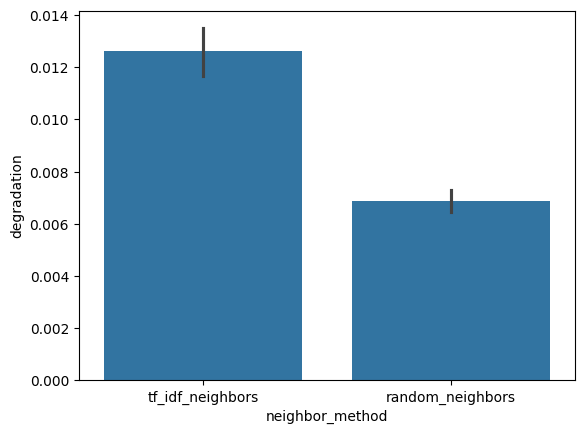

In [14]:
import plotly.express as px
import seaborn as sns

# mean_df_tfidf = mean_df[mean_df['neighbor_method'] == 'tf_idf_neighbors']
# tmp = mean_df.apply(lambda x : np.clip(
#     (np.exp(-x['neighborhood_prompt_post_obj_true']) - np.exp(-x['neighborhood_prompt_pre_obj_true']))*
#     np.exp(-x['neighborhood_prompt_pre_obj_true']),
#     a_max=0, a_min=-np.inf).sum() / np.exp(-x['neighborhood_prompt_pre_obj_true']).sum(), axis=1) * mean_df_tfidf['neighborhood_prompt_pre_obj_true'].apply(lambda x : np.exp(-x).mean())
s = pd.DataFrame({'degradation' : -mean_df['specificity_dd'], 'neighbor_method' : mean_df['neighbor_method']})
sns.barplot(s, x='neighbor_method', y='degradation')

**Conslusion** : TF-IDF neighbors are significantly more prone to bleedover

# Object type vs. performance

In [15]:
mean_df_tfidf = mean_df[(mean_df['neighbor_method'] == 'tf_idf_neighbors')]
metrics = mean_df_tfidf[mean_df_tfidf['algo'] != 'IDENTITY'].groupby(['algo', 'old_obj_type'])[['efficacy_s', 'generalization_s', 'specificity_dd', 'ngram_entropy']].agg(confidence_interval)
metrics

efficacy_s generalization_s    specificity_dd  \
algo        old_obj_type                                                       
FT_constr   Entity        0.5441 ± 0.0355  0.4200 ± 0.0326  -0.0045 ± 0.0006   
            Quantity      0.8258 ± 0.0299  0.5524 ± 0.0314  -0.0005 ± 0.0001   
            String        0.7500 ± 0.1294  0.6648 ± 0.1313  -0.0061 ± 0.0026   
FT_unconstr Entity        0.8103 ± 0.0279  0.8096 ± 0.0279  -0.0803 ± 0.0059   
            Quantity      1.0000 ± 0.0000  0.9988 ± 0.0018  -0.0042 ± 0.0004   
            String        0.9091 ± 0.0859  0.9034 ± 0.0861  -0.2587 ± 0.0484   
MEMIT       Entity        0.8937 ± 0.0210  0.8418 ± 0.0228  -0.0065 ± 0.0018   
            Quantity      0.9982 ± 0.0036  0.9259 ± 0.0157  -0.0000 ± 0.0000   
            String        0.9231 ± 0.0731  0.8798 ± 0.0813  -0.0012 ± 0.0009   
MEND        Entity        0.8709 ± 0.0239  0.8244 ± 0.0229  -0.0171 ± 0.0032   
            Quantity      1.0000 ± 0.0000  0.9786 ± 0.0082  -0.0020 ± 0.0003   
            String        0.9545 ± 0.0623  0.9489 ± 0.0629  -0.0190 ± 0.0128   
ROME        Entity        0.9300 ± 0.0180  0.8774 ± 0.0210  -0.0126 ± 0.0025   
            Quantity      0.9984 ± 0.0031  0.9338 ± 0.0117  -0.0001 ± 0.0000   
            String        0.9048 ± 0.1287  0.9643 ± 0.0511  -0.0024 ± 0.0020   

                            ngram_entropy  
algo        old_obj_type                   
FT_constr   Entity        5.4793 ± 0.0351  
            Quantity      5.1203 ± 0.0440  
            String        5.1850 ± 0.2098  
FT_unconstr Entity        1.9093 ± 0.0503  
            Quantity      2.2481 ± 0.0656  
            String        2.0785 ± 0.2216  
MEMIT       Entity        5.5281 ± 0.0329  
            Quantity      5.4275 ± 0.0437  
            String        5.4198 ± 0.1446  
MEND        Entity        5.1888 ± 0.0562  
            Quantity      4.9806 ± 0.0530  
            String        4.9102 ± 0.2401  
ROME        Entity        5.4699 ± 0.0385  
            Quantity      5.5514 ± 0.0441  
            String        5.1738 ± 0.4439

In [16]:
def argsort(frame : pd.DataFrame):
    for c in frame.columns:
        frame[c] = np.argsort(frame[c])
    return frame

def confidence_interval(frame : pd.DataFrame):
    m = frame.mean(axis=0, skipna=True)
    s = frame.std(axis=0, skipna=True)
    return '%.4f%s' % (m, ' (all)' if s == 0 else '')
    
metrics = mean_df_tfidf[mean_df_tfidf['algo'] != 'IDENTITY'].groupby(['algo', 'old_obj_type'])[['efficacy_s', 'generalization_s', 'specificity_dd', 'ngram_entropy']].mean()
metrics = metrics.groupby('algo').apply(argsort)
metrics.groupby('old_obj_type').agg(confidence_interval)

,efficacy_s,generalization_s,specificity_dd,ngram_entropy
old_obj_type,,,,
Entity,0.4000,0.0000 (all),1.2000,1.4000
Quantity,1.6000,1.6000,0.8000,1.2000
String,1.0000 (all),1.4000,1.0000 (all),0.4000


**Conclusions**:
- The difficulty of being "efficient" (in the sense of maximizing efficacy_s) in updating String objects always lies between updating Entities of Quantities.
- Generalization is most difficult when updating entities objects.

# Impact of popularity on performance

In [17]:
data.shape

AttributeError: 'dict' object has no attribute 'shape'

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

def plot_mean_with_ci(data, x_col, y_col, n_bins=10, ci=0.95, groupby=None, y_limit=None):
    """
    Plots mean of y_col per bin of x_col with confidence interval,
    optionally grouping by an additional column.

    Parameters:
    - data: pd.DataFrame
    - x_col: str
    - y_col: str
    - n_bins: int, optional
    - ci: float, optional
    - groupby: str, optional
    """
    # Create bins for x_col
    data['bin'] = pd.cut(data[x_col], bins=n_bins)
    min_y, max_y = float('inf'), -float('inf')
    if groupby:
        # Compute the mean and standard error of y_col per bin and group
        summary = data.groupby(['bin', groupby])[y_col].agg(['mean', 'sem', 'count']).reset_index()
        
        # Getting unique groups and bins for plotting and legend
        groups = summary[groupby].unique()
        bins = summary['bin'].unique()

        # Colors
        colors = plt.cm.viridis(np.linspace(0, 1, len(groups)))
        
        # Plotting
        for idx, group in enumerate(groups):
            group_data = summary[summary[groupby] == group]
            degrees_freedom = group_data['count'] - 1
            conf_int = group_data['sem'] * stats.t.ppf((1 + ci) / 2, degrees_freedom)
            min_y, max_y = min(min_y, -conf_int.min()+summary['mean'].min())-0.1, max(max_y, conf_int.max()+summary['mean'].max())+0.1
            plt.bar(x=np.arange(len(bins)) + idx*0.1, 
                    height=group_data['mean'], 
                    yerr=conf_int, 
                    alpha=0.7, 
                    capsize=5, 
                    color=colors[idx],
                    width=0.1,
                    label=group)
        
        plt.xticks(ticks=np.arange(len(bins)), labels=bins, rotation=45)
        plt.legend(title=groupby)
    else:
        # Compute the mean and standard error of y_col per bin
        summary = data.groupby('bin')[y_col].agg(['mean', 'sem', 'count'])
        
        # Compute the confidence interval
        degrees_freedom = summary['count'] - 1
        conf_int = summary['sem'] * stats.t.ppf((1 + ci) / 2, degrees_freedom)
        min_y, max_y = min(min_y, -conf_int.min()+summary['mean'].min())-0.05, max(max_y, conf_int.max()+summary['mean'].max())+0.05
        
        # Plotting
        plt.bar(x=np.arange(len(summary)), height=summary['mean'], yerr=conf_int, alpha=0.7, capsize=5)
        plt.xticks(ticks=np.arange(len(summary)), labels=summary.index, rotation=45)
        
    plt.ylabel(f'Mean of {y_col}')
    plt.xlabel(f'Bins of {x_col}')
    plt.title(f'Mean of {y_col} per Bin of {x_col} with {int(ci*100)}% CI')
    plt.tight_layout()
    plt.grid(axis='y')
    if y_limit:
        plt.ylim(y_limit)
    else:
        plt.ylim((min_y, max_y))

# Example usage:
# Assuming df is your DataFrame with columns "x" and "y".
# plot_mean_with_ci(df, x_col='x', y_col='y', n_bins=5, ci=0.95, groupby='group_col')


/tmp/ipykernel_880501/2059825155.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby('bin')[y_col].agg(['mean', 'sem', 'count'])
/tmp/ipykernel_880501/2059825155.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby('bin')[y_col].agg(['mean', 'sem', 'count'])
/tmp/ipykernel_880501/2059825155.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = data.groupby('bin')[y_

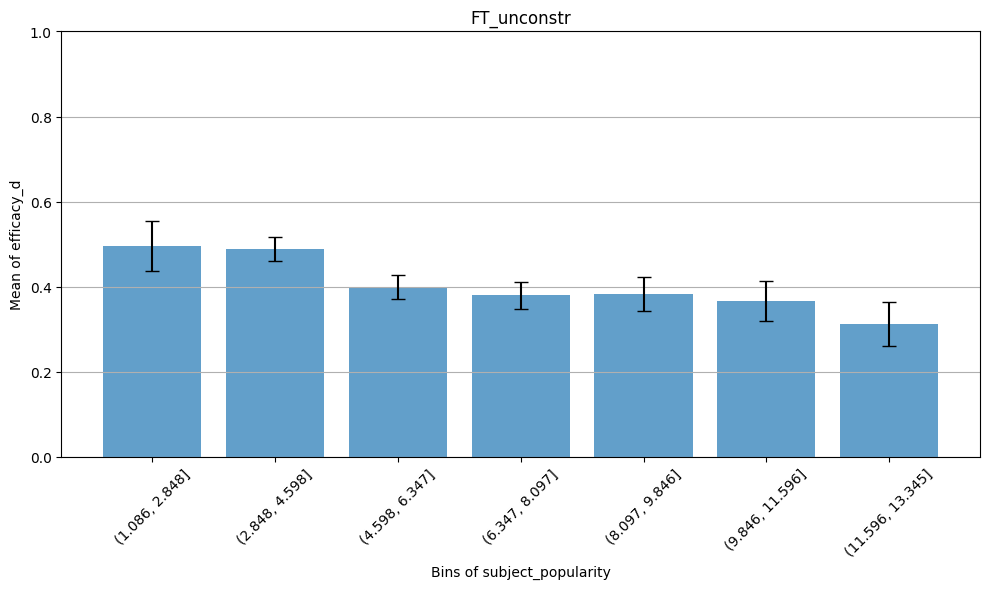

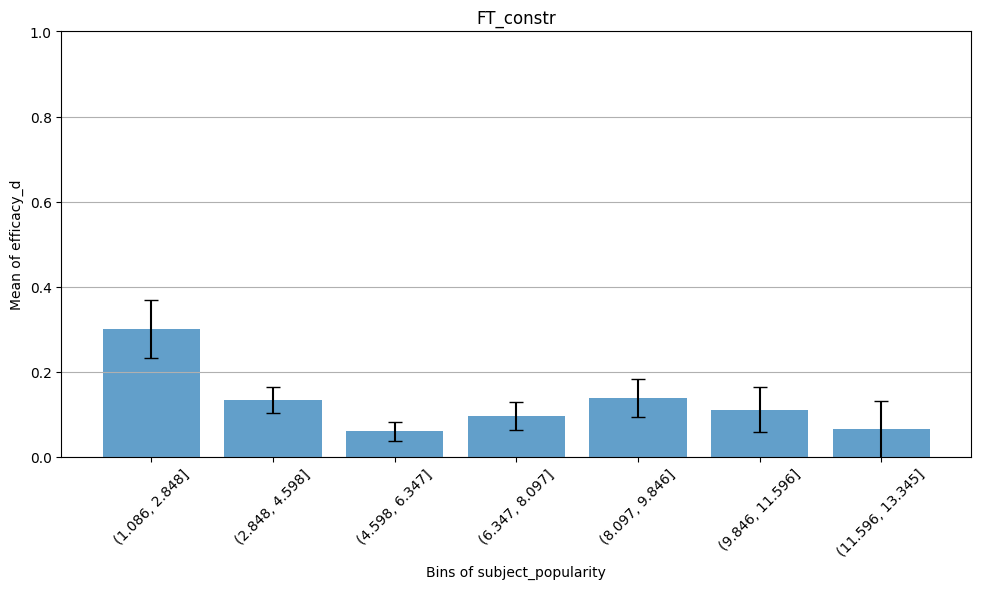

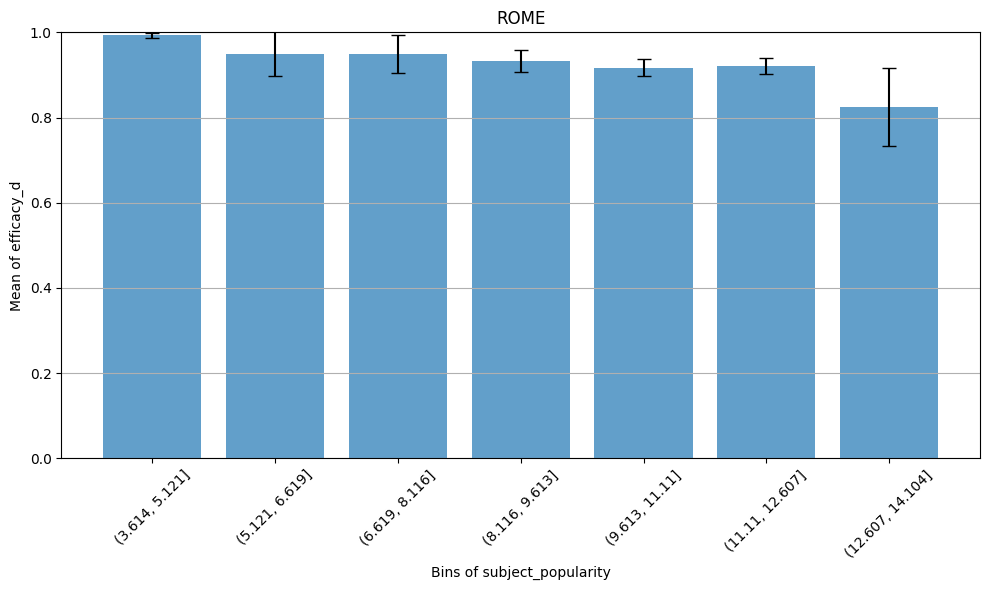

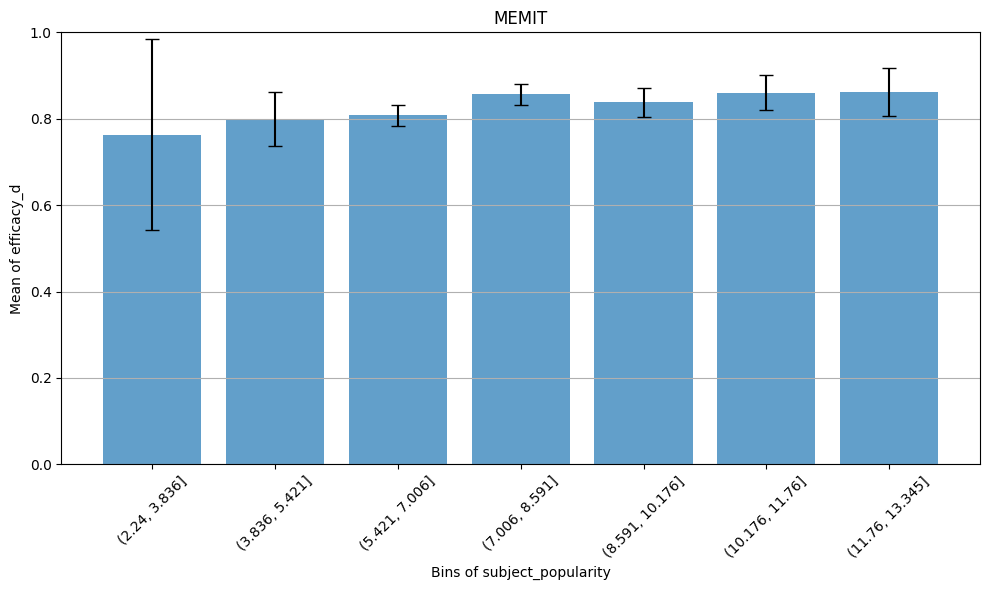

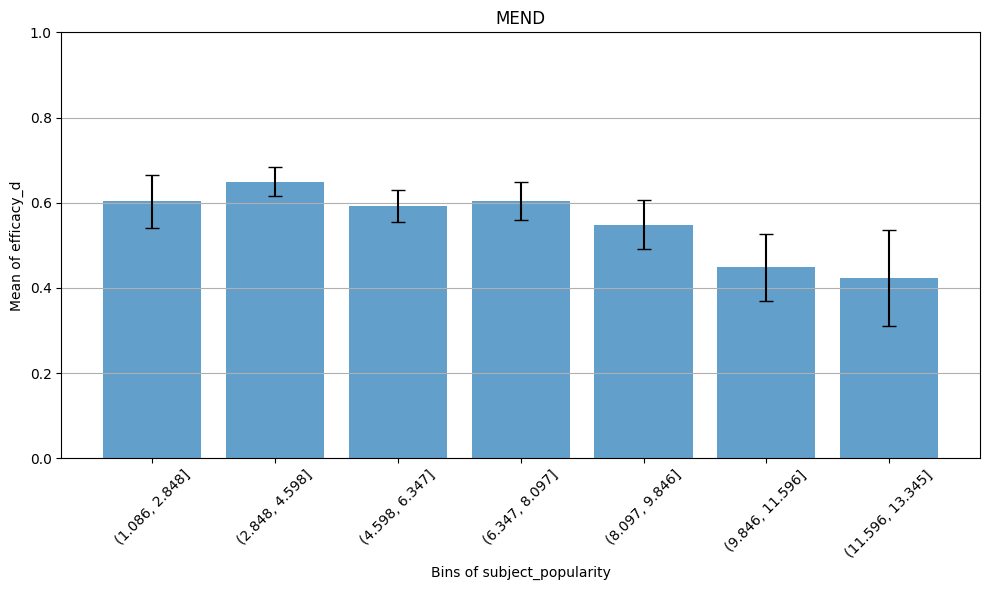

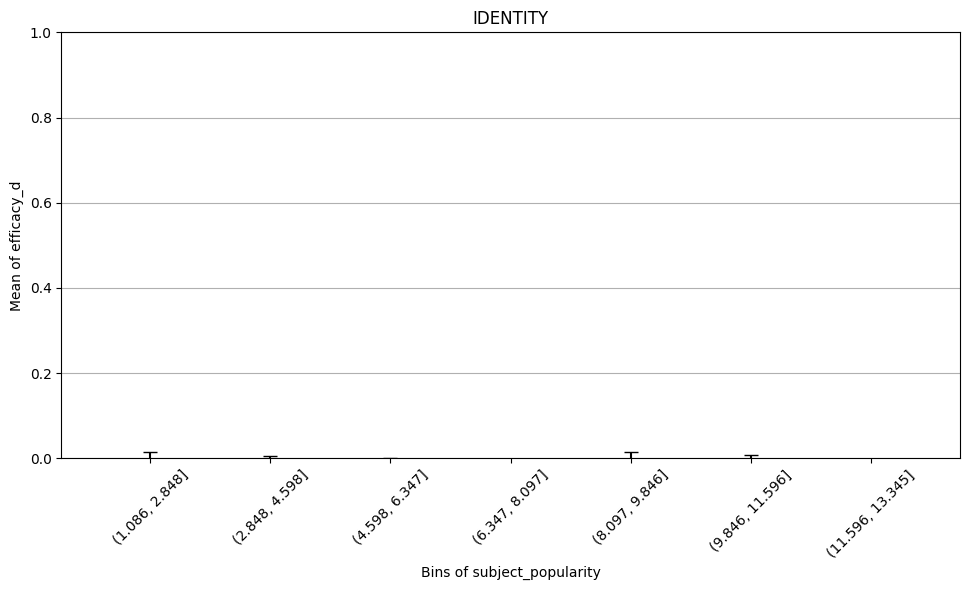

In [72]:
import matplotlib.pyplot as plt

x_label, y_label = 'subject_popularity', 'efficacy_d'
for algo in mean_df_tfidf['algo'].unique():
    data = mean_df_tfidf[[y_label, x_label, 'algo']][mean_df_tfidf['algo'] == algo].dropna()
    plt.figure(figsize=(10,6))
    plot_mean_with_ci(data, x_col=x_label, y_col=y_label, n_bins=7, ci=0.95, y_limit=(0,1))
    plt.title(algo)

## Notes subject popularity impact on performance



In [ ]:
s = [y for x in mean_df['neighborhood_distances'] for y in x]
d = mean_df.apply(lambda x : np.clip(np.exp(-x['neighborhood_prompt_post_obj_true']) - np.exp(-x['neighborhood_prompt_pre_obj_true']),a_max=0, a_min=-100000000000000), axis=1)
d = [y for x in d for y in x]
e = pd.DataFrame({'degradation' : -np.array(d), 'distance' : s})
sns.scatterplot(e, x='distance', y='degradation')